## Install/import required libraries

Note: script is built for colab, but can be run on local machine easily with small modifications (primarily for downloading images and installing packages)

In [1]:
# !pip install diffusers transformers accelerate safetensors

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

from diffusers import DiffusionPipeline


#### If necessary, update with working huggingface write token



In [ ]:
# !huggingface-cli login

## Generating an image with NARW LoRA example

In [ ]:
pipe_id = "stabilityai/stable-diffusion-xl-base-1.0"
pipe = DiffusionPipeline.from_pretrained(pipe_id, torch_dtype=torch.bfloat16).to("cuda")

pipe.load_lora_weights("henrysun9074/north-atlantic-right-whale-lora-mk-1", weight_name="north-atlantic-right-whale-lora-mk-1.safetensors", adapter_name="narw")
from diffusers import DPMSolverMultistepScheduler
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_attention_slicing()

prompt = "A drone photo of a north atlantic right whale swimming in the ocean"

lora_scale = 0.9 ## settings for image generation
image = pipe(
    prompt, num_inference_steps=30, cross_attention_kwargs={"scale": lora_scale}, generator=torch.manual_seed(0)
).images[0]
image



## Next step: test LoRA on batch generation

#### Pipeline setup for DreamBooth

In [6]:
# from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
# import torch

# pipe = DiffusionPipeline.from_pretrained("henrysun9074/dreambooth-out", torch_dtype=torch.bfloat16).to("cuda")
# pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
# pipe.enable_attention_slicing()
# prompt = "a drone image of a humpback whale"

# image = pipe(prompt).images[0]
# image

#### Pipeline setup for LoRA

In [7]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Initialize pipeline
pipe_id = "stabilityai/stable-diffusion-xl-base-1.0"
pipe = DiffusionPipeline.from_pretrained(pipe_id, torch_dtype=torch.bfloat16).to("cuda")
pipe.load_lora_weights("henrysun9074/drone-humpback-whale-lora-1", weight_name="drone-humpback-whale-lora-1.safetensors", adapter_name="humpback")
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_attention_slicing()

prompt = "A drone photo of a humpback whale swimming in the ocean"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

drone-humpback-whale-lora-1.safetensors:   0%|          | 0.00/93.1M [00:00<?, ?B/s]

## Batch generation:  
Adjust total_images and batch_size as needed. Change the manual seed offset to get novel outputs and break reproducibility

In [11]:
def get_inputs(batch_size, seed_offset):
    generator = [torch.Generator("cuda").manual_seed(seed_offset + i) for i in range(batch_size)]
    # generator = torch.Generator(device="cuda")
    prompts = batch_size * [prompt]
    num_inference_steps = 20
    return {"prompt": prompts, "generator": generator, "num_inference_steps": num_inference_steps}

# Generate images in multiple batches
def generate_images(pipe, total_images, batch_size):
    all_images = []
    seed_offset = 0  # For unique seeds across batches

    for _ in range(total_images // batch_size):
        inputs = get_inputs(batch_size, seed_offset)
        images = pipe(**inputs).images
        all_images.extend(images)

        # Free GPU memory
        torch.cuda.empty_cache()

        seed_offset += batch_size

    return all_images

total_images = 256
batch_size = 8
images = generate_images(pipe, total_images, batch_size)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

## Display images in a grid  

Adjust make_image_grid parameters so it multiplies to the total # of generated images

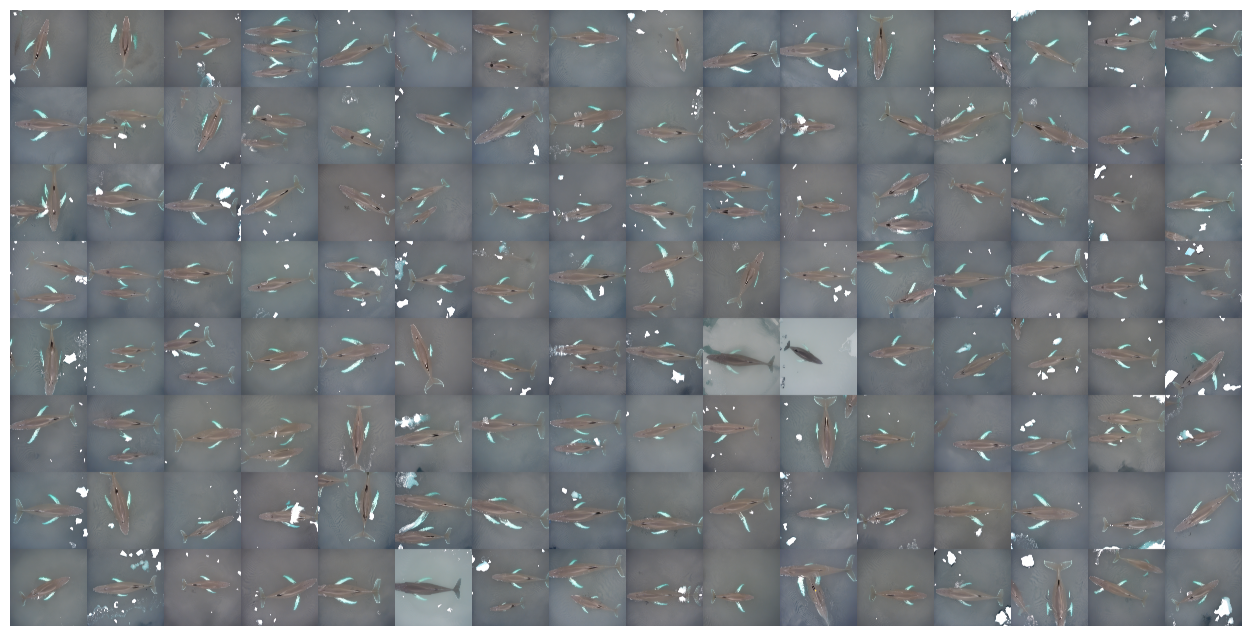

In [12]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def make_image_grid(images, rows, cols, scale_factor=2):
    # Resize images
    resized_images = [img.resize((img.width * scale_factor, img.height * scale_factor)) for img in images]

    img_width, img_height = resized_images[0].size
    grid_width = cols * img_width
    grid_height = rows * img_height

    # Create grid image
    grid = Image.new("RGB", (grid_width, grid_height))
    for i, img in enumerate(resized_images):
        grid.paste(img, box=(i % cols * img_width, i // cols * img_height))

    plt.figure(figsize=(cols, rows))
    plt.imshow(np.asarray(grid))
    plt.axis("off")
    plt.show()


make_image_grid(images, 8, 16, scale_factor=2)  # Adjust scale_factor as needed


## Download Images   
Note: designed for Colab, modify with os to work with local machine

In [10]:
import os
from PIL import Image
import zipfile
from google.colab import files

# Create a folder to store images
output_folder = "generated_images"
os.makedirs(output_folder, exist_ok=True)

# Save images
for idx, img in enumerate(images):
    img_path = os.path.join(output_folder, f"image_{idx + 1}.png")
    img.save(img_path)

# Compress images into a zip file
zip_path = f"{output_folder}.zip"
with zipfile.ZipFile(zip_path, "w") as zipf:
    for root, _, files in os.walk(output_folder):
        for file in files:
            zipf.write(os.path.join(root, file), arcname=file)

# Download the zip file
from google.colab import files
files.download(zip_path)


SyntaxError: invalid syntax (<ipython-input-10-25594b57ff9d>, line 24)